## Overview 

1. Pytorch & Tensorflow implementations are both tested and validated with the same number of Conv, Pooling and Linear Layers. 

2. Different number of layers are also used to test if it affects model accuracy. 

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### 1.1 Using Pytorch Convolutional Neural Network

**Model**: 2 Blocks of Convolutional-Maxpool pairs are used, with an activation function ReLu used.

**From Convolutional Layers to Linear Layers**
After going through the convolution layers, we would get an output x, such that x.shape = `[10,12,5,5]`, which implies:

1. We have 10 images in a batch 

2. Each image have 12 channels / Feature maps 

3. Each feature map is of size 5x5 

When we pass it into the linear layers, we must flatten all the feature maps into a single vector. Keeping the dimension of the reshaped tensor to be the total element, we perform `x.view(x.size(0))`, as `x.size(0)` retrieves the number of images in the batch.

The remaining parameters should also be evalutated into a single vector, instead of `channels * mat_dim * mat_dim`,  thus `x.view(x.size(0), -1)` would evaluate these parameters in Pytorch.

In [2]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.conv_layers = nn.Sequential( # Sequential wraps the layers - In this case, we seperate into the base and head layer. 
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), 
                nn.ReLU(), 
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1), 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2) 
        )
        self.linear_layers  = nn.Sequential(
                nn.Linear(in_features=24*7*7, out_features=64),           
                nn.ReLU(),
                nn.Dropout(p=0.1),
                nn.Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        '''
        Passes the input through each defined layers 
        '''
        x = self.conv_layers(x) 
        x = x.view(x.size(0), -1) # 
        x = self.linear_layers (x) 
        return x # returns a raw score for each class (10 in this case) that is passed into softmax function for a probability (label)
        
net = Network()
optimizer = optim.SGD(net.parameters(), lr=0.01) # update rule of the network weights
criterion = nn.CrossEntropyLoss() # loss function

### 1.2 Loading of Data and batching it to feed into the model 

`Pytorch Dataloader` is used to load batches of data inside and randomizes the batch for training

`__len__` : len(dataset) returns the size of the dataset.

`__getitem__` to support the indexing such that dataset[i] can be used to get ith sample.

In [18]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob

test_directory = "../MNIST Dataset JPG format/MNIST - JPG - testing"
training_directory = '../MNIST Dataset JPG format/MNIST - JPG - training'

class CustomDataset(Dataset):
    def __init__(self, directory, transform=None):
        '''
        Contains Train & Test folders with folders labelled 0 - 9. 
        
        In each folder contains a handwritten digit of the labelled folder number, but the image names are unanalogous to the number shown
        '''
        self.directory = directory
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in range(10): # 0 , 1 , 2 ... 9 
            subfolder = os.path.join(directory, str(label))
            for image_path in glob.glob(os.path.join(subfolder, '*.jpg')): # Wildcard to match all the image name in the subfolder | glob finds all the pathnames of the specified path
                self.image_paths.append(image_path)
                self.labels.append(label)
                '''
                image_paths would be an array of file path from all subfolders
                
                labels would be also an array of the same size, and the same index of the labels array matches the index of the image paths 
                '''

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label

# Transforms such that the image can be fitted into the mdoel 
transform = transforms.Compose([
    transforms.Grayscale(),  # grayscale image 
    transforms.Resize((28, 28)),  # Resize 
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize
])

#### 1.2.1 Testing the Custom Dataset Class 

In [26]:
testing_custom_data = CustomDataset(training_directory, transform=transform)

print('Labels Array', testing_custom_data.labels[:30]) 
print('Path Array', testing_custom_data.image_paths[:30]) 

Labels Array [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Path Array ['../MNIST Dataset JPG format/MNIST - JPG - training\\0\\1.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\1000.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\10005.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\10010.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\10022.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\10025.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\10026.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\10045.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\10069.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\10071.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\10080.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\10083.jpg', '../MNIST Dataset JPG format/MNIST - JPG - training\\0\\10107.jpg', '../M

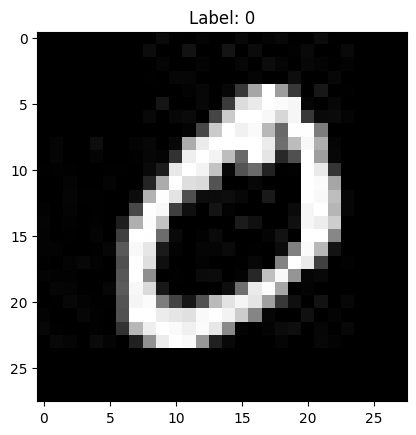

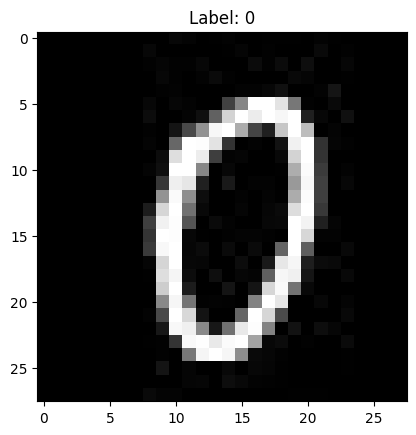

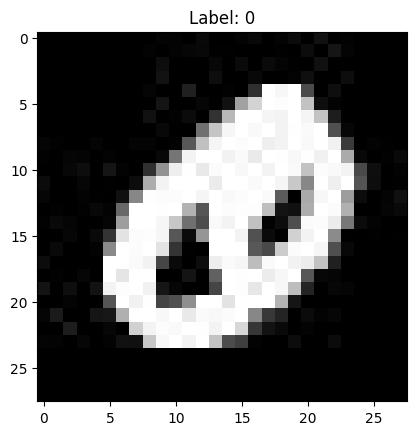

In [27]:
# show image
def show_image(img, label):
    img = img.numpy().squeeze()
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {label}")
    plt.show()

# Test data loader 
for i in range(3):
    image, label = testing_custom_data[i]
    show_image(image, label)

#### 1.2.2 Testing the Dataloader that helps to batch the data for training 

Dataloader samples different singular points from the defined 1D array and gathers 64 Points randomly. 

The `DataLoader` yields an iteratable, from a queue of batches. Iterating through the object would give us our batches. Number of Batches = Total Samples / Batch Size 

Each batch contains 64 data points as specified. When these images are loaded into a tensor for a batch, the tensor's shape is `[batch_size, channels, height, width]`, with the height and width forming a 28x28 matrix in this context, and the indiviudal points being a numeric feature of the MNIST image.

In [37]:
testing_loader = DataLoader(testing_custom_data, batch_size=64, shuffle=True)

features, labels = next(iter(testing_loader)) # Converts the testing loader into an iterator to iterate from, next(.) retrieves the next item in the iterator.  
print(features) # Output of dataloader would yield a pair of features (in the form of tensor) & their respective labels 
print(labels)

tensor([[[[-1.0000, -0.9373, -0.9529,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9922, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.000

### 1.3 Training of model 

During each epoch, we train and test the model. We should expect both drop in loss for training and evaluation in each epoch.

Epoch 1/10, Training Loss: 1.457948869717782, Validation Loss: 0.3310965320486931


Epoch 2/10, Training Loss: 0.2647860849907657, Validation Loss: 0.1610254124044233


Epoch 3/10, Training Loss: 0.16909149679532057, Validation Loss: 0.11343073803385731


Epoch 4/10, Training Loss: 0.12990057492243456, Validation Loss: 0.08731826387084783


Epoch 5/10, Training Loss: 0.10951614659875314, Validation Loss: 0.0791523511029163


Epoch 6/10, Training Loss: 0.09467655496655909, Validation Loss: 0.06875322324336525


Epoch 7/10, Training Loss: 0.0851335146877446, Validation Loss: 0.05949900076861025


Epoch 8/10, Training Loss: 0.0767255085515482, Validation Loss: 0.0582579398842137


Epoch 9/10, Training Loss: 0.07122853891487156, Validation Loss: 0.05052659131147584


Epoch 10/10, Training Loss: 0.06613721998720201, Validation Loss: 0.04871721670423059


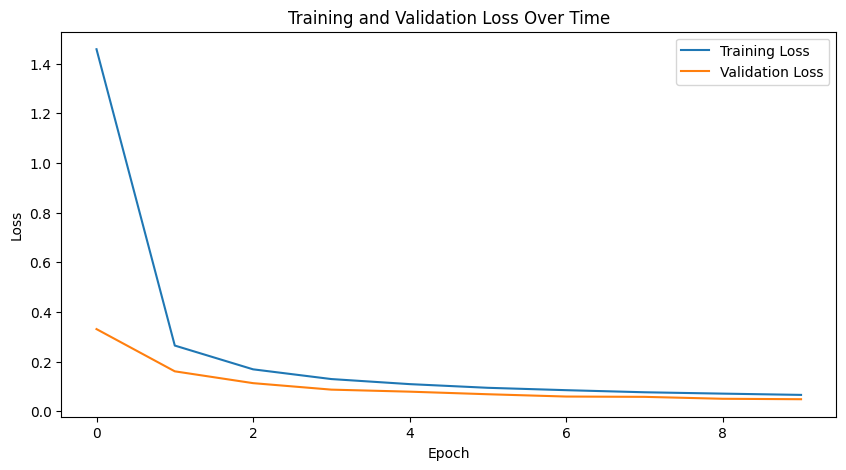

In [38]:
from tqdm import tqdm

# Initialize custom datasets
training_dataset = CustomDataset(training_directory, transform=transform)
testing_dataset = CustomDataset(test_directory, transform=transform)

# Data loaders
train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=64, shuffle=True)

# lists for tracking losses
train_losses = []
val_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    net.train()  # Set the model to training mode
    total_train_loss = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

    for images, labels in progress_bar:
        outputs = net(images) # Forward pass 
        
        loss = criterion(outputs, labels) # Calcualtes loss from each pass 

        optimizer.zero_grad() # Clears the old gradient
        loss.backward() # Backward pass
        optimizer.step() # optimization

        total_train_loss += loss.item()
        
        progress_bar.set_postfix(loss=loss.item())

    # Calculate average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step - Evalutates model on Test data. A lower loss means that infered image is close to actual image, hence lower is better 
    net.eval()  # evaluation mode
    total_val_loss = 0
    with torch.no_grad(): # no_grad is used for training, in evalutaion we disable it to save compuatational power 
        for images, labels in test_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 1.4 Percentage Accuracy of Pytorch model 

The output from the pass would be a tensor of **Dimension**: `Number of image in a batch * Number of classes predicting`

However, the meaning of each row * column = `Score of predicted class` * `Index of class with that assoicated score`

Since we have 64 images and 10 classes, we have `64*10`

Example of data:

...

[x1, x2, ..., x10] ,

[y1, y2, ..., y10],

[z1, z2, ..., z10]

`torch.max(outputs, 1)`: Finds the maximum score along the dimension 1 (Columns) of the given tensor. 

In [40]:
net.eval() 

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images) 
        
        _, max_score_index = torch.max(outputs, 1) # ignore the actual predicted score, we just want the index of the class that was predicted 
        
        total_predictions += labels.size(0)

        correct_predictions += (max_score_index == labels).sum().item()

    accuracy = 100 * correct_predictions / total_predictions

    print('Accuracy of Model: ', accuracy)

Accuracy of Model:  98.47


In [6]:
torch.save(net.state_dict(), 'net.pth')

In [41]:
print("Number of training data:", training_dataset.__len__)
print("Number of testing data:", testing_dataset.__len__)

Number of training data: <bound method CustomDataset.__len__ of <__main__.CustomDataset object at 0x0000022DE4B98DF0>>
Number of testing data: <bound method CustomDataset.__len__ of <__main__.CustomDataset object at 0x0000022DE8DF98E0>>
